In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import f1_score

sys.path.insert(1, os.path.join(sys.path[0], "code/implementation"))
from layer_v2 import Layer
from neural_network_v2 import NeuralNetwork

In [10]:
def visualize_fit_of_regression(data_frame, neural, std):
    y = neural.predict(data_frame["x"])
    plt.scatter(data_frame["x"], y, c="red")
    plt.scatter(data_frame["x"], data_frame["y"], c="blue")
    plt.legend(["Prediction", "True"])
    return neural.calculate_cost(data_frame["x"], data_frame["y"]) * std["y"] ** 2

In [11]:
multimodal_train = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-training.csv"
)
multimodal_test = pd.read_csv(
    "https://raw.githubusercontent.com/nizwant/miowid/main/data/regression/multimodal-large-test.csv"
)
mean = multimodal_train.mean()
std = multimodal_train.std()
multimodal_train = (multimodal_train - mean) / std
multimodal_test = (multimodal_test - mean) / std

# Joke but works surprisingly well  

In [62]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 20, "relu"))
neural.add_layer(Layer(20, 100, "relu"))
neural.add_layer(Layer(100, 1, "linear"))
mse = neural.train(multimodal_test["x"], multimodal_test["y"], max_num_epoch=1500, learning_rate=0.001)

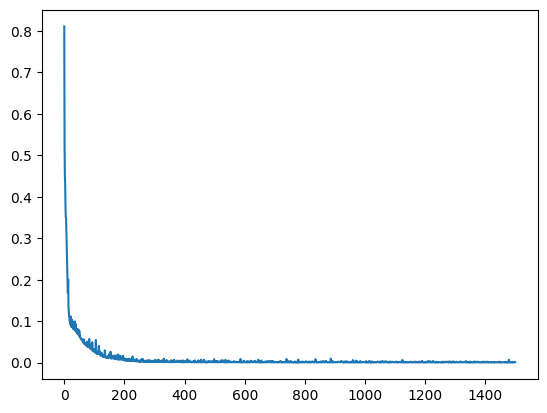

In [65]:
plt.plot(mse)

3.99819177606917

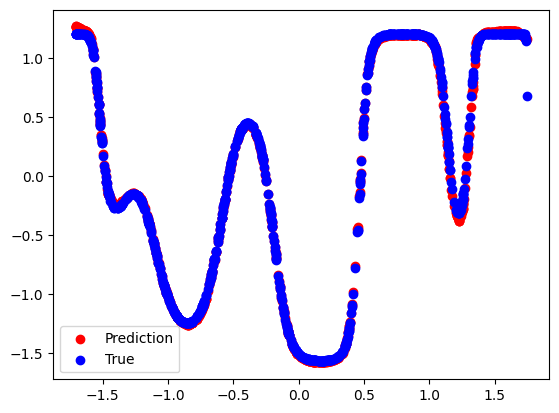

In [64]:
visualize_fit_of_regression(multimodal_test, neural, std)

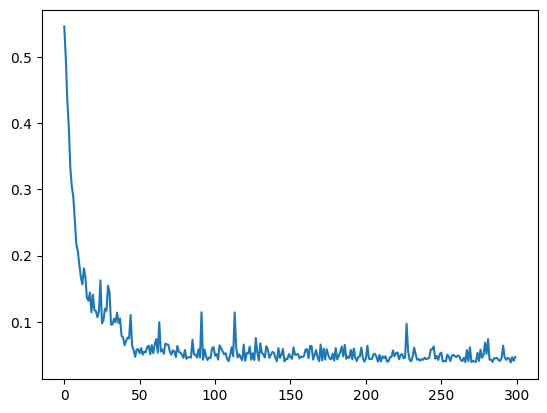

In [83]:
neural = NeuralNetwork(cost_function="mse")
neural.add_layer(Layer(1, 10, "relu"))
neural.add_layer(Layer(10, 10, "relu"))
neural.add_layer(Layer(10, 1, "linear"))
mse = neural.train(
    multimodal_test["x"], multimodal_test["y"], max_num_epoch=300, learning_rate=0.01
)
plt.plot(mse)

260.18254576183864

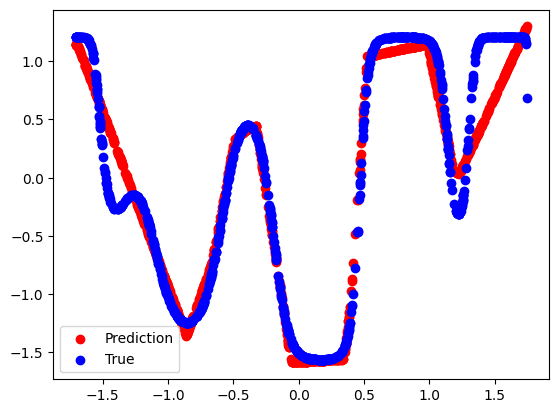

In [84]:
visualize_fit_of_regression(multimodal_test, neural, std)

In [12]:
activation_functions = ["relu", "sigmoid", "tanh", "linear", "leaky_relu"]
initialization_methods = [
    "normal",
    "uniform_xavier",
    "he",
    "normal_xavier",
    "uniform_minus_one_one",
    "uniform_zero_one",
]
number_of_repetition = 1 # 10

In [13]:
from collections import defaultdict 
df = pd.DataFrame(columns=["Initialization", "Activation", "Hidden Layers", "Cost"])
after_epoch_dict = defaultdict(lambda: []) 

for initialization_method in initialization_methods:
    for activation in activation_functions:
        for _ in range(number_of_repetition):
            # One hidden layer creation
            one_hidden = NeuralNetwork(cost_function="mse")
            one_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            one_hidden.add_layer(Layer(10, 1, "linear"))

            # Two hidden layers creation
            two_hidden = NeuralNetwork(cost_function="mse")
            two_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            two_hidden.add_layer(Layer(10, 1, "linear"))

            # Three hidden layers creation
            three_hidden = NeuralNetwork(cost_function="mse")
            three_hidden.add_layer(
                Layer(1, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(
                Layer(10, 10, activation, weight_initialization=initialization_method)
            )
            three_hidden.add_layer(Layer(10, 1, "linear"))

            # Training
            one_cost_after_epoch = one_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
            )
            two_cost_after_epoch = two_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
            )
            three_cost_after_epoch = three_hidden.train(
                multimodal_train["x"],
                multimodal_train["y"],
                max_num_epoch=200,
                learning_rate=0.01,
            )

            # Testing
            one_hidden_test_cost = one_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            two_hidden_test_cost = two_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )
            three_hidden_test_cost = three_hidden.calculate_cost(
                multimodal_test["x"], multimodal_test["y"]
            )

            # Saving cost after training results
            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "1",
                one_hidden_test_cost,
            ]

            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "2",
                two_hidden_test_cost,
            ]

            df.loc[len(df.index)] = [
                initialization_method,
                activation,
                "3",
                three_hidden_test_cost,
            ]

            after_epoch_dict[
                f"{initialization_method}/{activation}/1"
            ].append(one_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/2"
            ].append(two_cost_after_epoch)
            after_epoch_dict[
                f"{initialization_method}/{activation}/3"
            ].append(three_cost_after_epoch)
    print(f"Initialization method {initialization_method} done")

In [14]:
df 

,Initialization,Activation,Hidden Layers,Cost
0,normal,relu,1,0.101519
1,normal,relu,2,0.008719
2,normal,relu,3,0.000748
3,normal,sigmoid,1,0.007433
4,normal,sigmoid,2,0.000839
...,...,...,...,...
85,uniform_zero_one,linear,2,0.856567
86,uniform_zero_one,linear,3,0.865847
87,uniform_zero_one,leaky_relu,1,0.250585
88,uniform_zero_one,leaky_relu,2,0.017877


Text(0.5, 1.0, 'Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization')

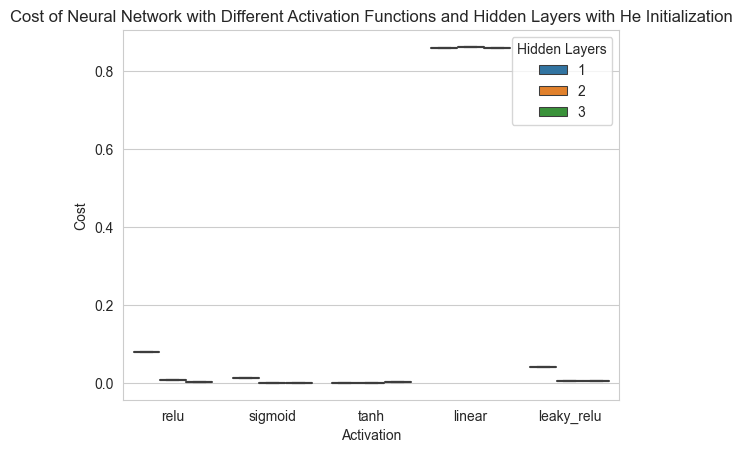

In [15]:
import seaborn as sns
sns.set_style("whitegrid")
df_he = df[df["Initialization"] == "he"]
sns.boxplot(x="Activation", y="Cost", data=df_he, hue="Hidden Layers")
plt.title(
    "Cost of Neural Network with Different Activation Functions and Hidden Layers with He Initialization"
)

In [16]:
after_epoch_dict

defaultdict(<function __main__.<lambda>()>,
            {'normal_relu_1': [[0.49163948105176525,
               0.3785337366883261,
               0.3271955532291636,
               0.3195770066247578,
               0.3183396114271397,
               0.3098524645143655,
               0.29847548341757313,
               0.29792716238194583,
               0.3162567382165519,
               0.3146518392669829,
               0.29011190987042623,
               0.3155791504051336,
               0.2945911238470079,
               0.29204842589064367,
               0.32359983597499886,
               0.29487550082069586,
               0.2898199802015695,
               0.28924520141474197,
               0.28341916300222053,
               0.3113697279975908,
               0.2903886062066969,
               0.28443014343803624,
               0.3083629574993573,
               0.3017047969801529,
               0.3083386300797325,
               0.28317810868430754,
               0.2

Text(0, 0.5, 'MSE')

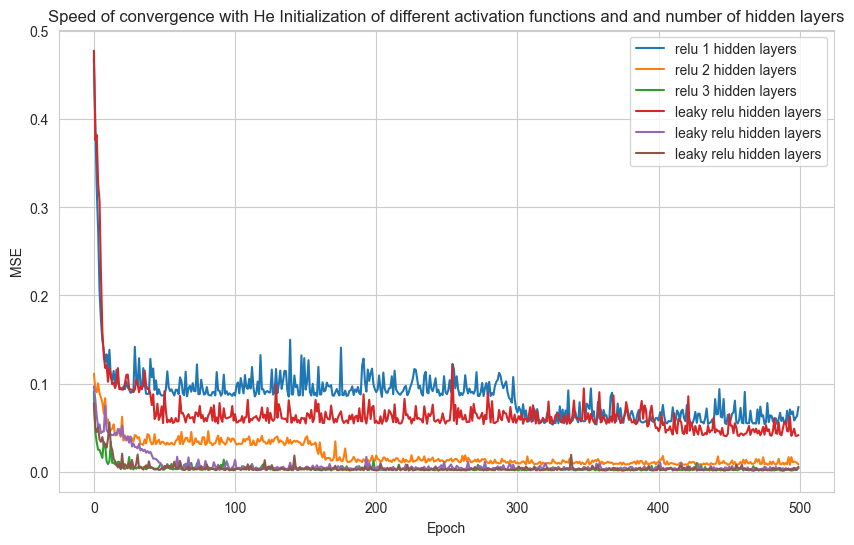

In [23]:
plt.figure(figsize=(10, 6))
for key, value in after_epoch_dict.items():
    key  = key.split("/")
    label = f"{key[1]} {key[2]} hidden layers"
    if key[0] == "he" and (key[1] == "relu" or key[1] == "leaky"):
        plt.plot(np.mean(value, axis=0), label=label)
plt.legend()
plt.title("Speed of convergence with He Initialization of different activation functions and and number of hidden layers")
plt.xlabel("Epoch")
plt.ylabel("MSE")